#Set Dependencies

## Upload the kaggle credential json file

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hamdiazhari","key":"327b3081f0511c196ce37f1defdcf197"}'}

## mount the google drive for saving the trained model later

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
! git clone https://github.com/bangkitjkt/final-project-ODIR5K.git /tmp/final-project-ODIR5K

#install last update tensorflow addons
! sudo python3 -m pip install /tmp/final-project-ODIR5K/model/python_package/*.whl

Cloning into '/tmp/final-project-ODIR5K'...
remote: Enumerating objects: 471, done.
remote: Total 471 (delta 0), reused 0 (delta 0), pack-reused 471
Receiving objects: 100% (471/471), 904.18 MiB | 39.79 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Checking out files: 100% (283/283), done.
Processing /tmp/final-project-ODIR5K/model/python_package/tensorflow_addons-0.11.0.dev0-cp36-cp36m-linux_x86_64.whl
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## Download the dataset from kaggle

In [5]:
import zipfile

! kaggle datasets download -d 'andrewmvd/ocular-disease-recognition-odir5k' -p '/tmp'

local_zip = '/tmp/ocular-disease-recognition-odir5k.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

100% 1.25G/1.26G [00:57<00:00, 20.9MB/s]
100% 1.26G/1.26G [00:57<00:00, 23.2MB/s]


In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

import tensorflow as tf
import tensorflow_addons as tfa
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import tensorflow.keras.optimizers

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import cv2

import os
import shutil
from random import sample

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.2.0


In [7]:
os.chdir('/tmp/ODIR-5K')

# Data Preprocessing

In [8]:
from pandas import read_excel

my_sheet = 'Sheet1'
file_name = '/tmp/ODIR-5K/data.xlsx'
df = read_excel(file_name, sheet_name = my_sheet)
print(df.head())

   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  ...  C  A  H  M  O
0   0           69      Female  0_left.jpg  0_right.jpg  ...  1  0  0  0  0
1   1           57        Male  1_left.jpg  1_right.jpg  ...  0  0  0  0  0
2   2           42        Male  2_left.jpg  2_right.jpg  ...  0  0  0  0  1
3   3           66        Male  3_left.jpg  3_right.jpg  ...  0  0  0  0  1
4   4           53        Male  4_left.jpg  4_right.jpg  ...  0  0  0  0  1

[5 rows x 15 columns]


In [9]:
leftEyeKeywords = df['Left-Diagnostic Keywords'].copy()
rightEyeKeywords = df['Right-Diagnostic Keywords'].copy()

In [10]:
leftEyeKeywords = leftEyeKeywords.str.split("，")
rightEyeKeywords = rightEyeKeywords.str.split("，")

In [11]:
leftEyeKeywords[2]

['laser spot', 'moderate non proliferative retinopathy']

## set the different keyword diagnosis label

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

res = pd.DataFrame(mlb.fit_transform(rightEyeKeywords),
                   columns=mlb.classes_,
                   index=rightEyeKeywords.index)

allDiagnosisLeft = res.columns.to_list()
len(allDiagnosisLeft)

res = pd.DataFrame(mlb.fit_transform(leftEyeKeywords),
                   columns=mlb.classes_,
                   index=leftEyeKeywords.index)

allDiagnosisRight = res.columns.to_list()
len(allDiagnosisRight)

allDiagnosis=list(set(allDiagnosisLeft+allDiagnosisRight))
print("total different keys diagnosis :", len(allDiagnosis))

total different keys diagnosis : 105


## get keywords from single label

In [13]:
test_df = df.copy()
doubleDiagnosisRow = []

def getKeyDiagnosisSingle(colName):
  keyDiagnosis = []
  global doubleDiagnosisRow
  store = True
  for row in range(len(test_df[colName])):
    store = True
    if test_df[colName][row] == 1:
      for lable in test_df.columns[7:]:
        if lable == colName:
          continue
        if test_df[lable][row] == 1:
          doubleDiagnosisRow.append(row)
          store = False
          break
        
      if store == True:
        for i in rightEyeKeywords[row]:
          keyDiagnosis.append(i)
        for i in leftEyeKeywords[row]:
          keyDiagnosis.append(i)
      

  keyDiagnosis = list(set(keyDiagnosis))
  return keyDiagnosis

keyNormal = getKeyDiagnosisSingle(test_df.columns[7])
keyDiabetes = getKeyDiagnosisSingle(test_df.columns[8])
keyGlaucoma = getKeyDiagnosisSingle(test_df.columns[9])
keyCataract = getKeyDiagnosisSingle(test_df.columns[10])
keyAMD = getKeyDiagnosisSingle(test_df.columns[11])
keyHypertension = getKeyDiagnosisSingle(test_df.columns[12])
keyMyopia = getKeyDiagnosisSingle(test_df.columns[13])
keyOtherDisease = getKeyDiagnosisSingle(test_df.columns[14])

labelString = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Abnormalities']
keyAll = [keyNormal, keyDiabetes, keyGlaucoma, keyCataract, keyAMD, keyHypertension, keyMyopia, keyOtherDisease]

for i in range(8):
  print(labelString[i], len(keyAll[i]))

keyNormal

Normal 3
Diabetes 10
Glaucoma 5
Cataract 3
AMD 3
Hypertension 1
Myopia 6
Abnormalities 57


['normal fundus', 'lens dust', 'low image quality']

In [14]:
print("intersect by normal :\n")
for i in range(1,len(keyAll)):
  keyAll[i] = list(set(keyAll[i])-set(keyAll[0]))

for i in range(8):
  print(labelString[i], len(keyAll[i]))

print("\nintersect by other :\n")
for i in range(len(keyAll)):
  for j in range(i,len(keyAll)):
    if i == j:
      continue
    else :
      keyAll[i] = list(set(keyAll[i])-set(keyAll[j]))

for i in range(8):
  print(labelString[i], len(keyAll[i]))

intersect by normal :

Normal 3
Diabetes 8
Glaucoma 3
Cataract 1
AMD 2
Hypertension 1
Myopia 4
Abnormalities 54

intersect by other :

Normal 3
Diabetes 7
Glaucoma 3
Cataract 1
AMD 2
Hypertension 1
Myopia 4
Abnormalities 54


In [15]:
def getAllRecognizedKey(mkeyAll):
  mallkeyDiagnosis = []
  for i in range(len(mkeyAll)):
    mkeyAll[i] = list(set(mkeyAll[i]))
    mallkeyDiagnosis = mallkeyDiagnosis+list(set(mkeyAll[i]))
  return mallkeyDiagnosis

In [16]:
keyNormal, keyDiabetes, keyGlaucoma, keyCataract, keyAMD, keyHypertension, keyMyopia, keyOtherDisease = keyAll[0], keyAll[1], keyAll[2], keyAll[3], keyAll[4], keyAll[5], keyAll[6], keyAll[7]

allkeyDiagnosis = getAllRecognizedKey(keyAll)
len(allkeyDiagnosis)

75

In [17]:
doubleDiagnosisRow = list(set(doubleDiagnosisRow))
print("double lablel row ",len(doubleDiagnosisRow))
doubleDiagnosisRow.sort()
# doubleDiagnosisRow

double lablel row  586


In [18]:
notlisted = []
listed = False
for row in doubleDiagnosisRow:
  # print(row)
  for ilist in leftEyeKeywords[row]:
    # print(ilist)
    listed = False
    for j in keyAll:
      if ilist in j:
        listed = True
        break
    if listed == False:
      notlisted.append(ilist)

for row in doubleDiagnosisRow:
  for ilist in rightEyeKeywords[row]:
    listed = False
    for j in keyAll:
      if ilist in j:
        listed = True
        break
    if listed == False:
      notlisted.append(ilist)

notlisted = list(set(notlisted))
# notlisted
print("not listed diagnosis key :",len(notlisted))

not listed diagnosis key : 30


## get keywords from multilabel

In [19]:
def intersectFromMultiLabel(mkeyAll):
  mnotRecognizedList = []
  mallkeyDiagnosis = []
  for i in range(len(mkeyAll)):
    mkeyAll[i] = list(set(mkeyAll[i]))
    mallkeyDiagnosis = mallkeyDiagnosis+list(set(mkeyAll[i])) 
  for row in doubleDiagnosisRow:
    notlistedList = []
    listedList = []
    colIndex = []
    ind = []
    tempList = []
    for ilist in leftEyeKeywords[row]:
      if ilist not in mallkeyDiagnosis:
        tempList.append(ilist)
    for ilist in rightEyeKeywords[row]:
      if ilist not in mallkeyDiagnosis:
        tempList.append(ilist)

    for i in range(7, len(test_df.columns)):
      if test_df[test_df.columns[i]][row] == 1:
        colIndex.append(i-7)
    tempList = list(set(tempList))
    isContainAbnormal = 7 in colIndex
    if len(tempList) > 0:
      ind = colIndex
      for ilist in leftEyeKeywords[row]:
        if ilist not in tempList:
          listedList.append(ilist)
      for ilist in rightEyeKeywords[row]:
        if ilist not in tempList:
          listedList.append(ilist)
      
      for ilist in listedList:
        for i in colIndex:    
          if ilist in keyNormal:
            continue
          if ilist in mkeyAll[i]:
            ind.remove(i)

      if len(ind) == 0 and isContainAbnormal:
        ind.append(7)
      if len(ind) == 1 and len(tempList) == 1:
        mkeyAll[ind[0]] = mkeyAll[ind[0]] + tempList
        mkeyAll[ind[0]] = list(set(mkeyAll[ind[0]]))
      else:
        print("not recognize")
        mnotRecognizedList.append(tempList[0])
        mnotRecognizedList = list(set(mnotRecognizedList))

    mallkeyDiagnosis = []
    for i in mkeyAll:
      mallkeyDiagnosis = mallkeyDiagnosis+list(set(i))
  return mkeyAll, mnotRecognizedList

In [20]:
itterate = True
notRecognizedList = []
while itterate :
  temp_allkeyDiagnosis = allkeyDiagnosis.copy()
  keyAll, notRecognizedList = intersectFromMultiLabel(keyAll)
  allkeyDiagnosis = getAllRecognizedKey(keyAll)
  # print(len(temp_allkeyDiagnosis), len(allkeyDiagnosis))
  print(notRecognizedList)
  if len(temp_allkeyDiagnosis) == len(allkeyDiagnosis):
    print(True)
    itterate = False

not recognize
not recognize
not recognize
['punctate inner choroidopathy', 'suspected cataract', 'image offset']
not recognize
not recognize
['suspected cataract', 'image offset']
not recognize
not recognize
['suspected cataract', 'image offset']
True


In [21]:
allkeyDiagnosis = getAllRecognizedKey(keyAll)

keyNormal, keyDiabetes, keyGlaucoma, keyCataract, keyAMD, keyHypertension, keyMyopia, keyOtherDisease = keyAll[0], keyAll[1], keyAll[2], keyAll[3], keyAll[4], keyAll[5], keyAll[6], keyAll[7]

for i in range(8):
  print(labelString[i], len(keyAll[i]))

print("\nall regnized key :",len(allkeyDiagnosis))
print("\nnot recognized key : ", list(set(allDiagnosis)-set(allkeyDiagnosis)))

Normal 3
Diabetes 11
Glaucoma 3
Cataract 1
AMD 3
Hypertension 1
Myopia 5
Abnormalities 76

all regnized key : 103

not recognized key :  ['suspected cataract', 'image offset']


## add non recognized label to a label with the likelihood of approaching

In [22]:
#manual listing key

string = 'suspected cataract'
string2 = 'image offset'
if string in notRecognizedList and string not in allkeyDiagnosis:
  keyAll[3].append(string)
  notRecognizedList.remove(string)

if string2 in notRecognizedList and string not in allkeyDiagnosis:
  print(True)
  keyAll[4].append(string2)
  notRecognizedList.remove(string2)

True


In [23]:
keyAll[4]

['dry age-related macular degeneration',
 'age-related macular degeneration',
 'wet age-related macular degeneration',
 'image offset']

In [24]:
allkeyDiagnosis = getAllRecognizedKey(keyAll)

keyNormal, keyDiabetes, keyGlaucoma, keyCataract, keyAMD, keyHypertension, keyMyopia, keyOtherDisease = keyAll[0], keyAll[1], keyAll[2], keyAll[3], keyAll[4], keyAll[5], keyAll[6], keyAll[7]

for i in range(len(keyAll)):
  print(labelString[i], len(keyAll[i]))

print("\nall regnized key :",len(allkeyDiagnosis))
print("\nnot recognized key : ", list(set(allDiagnosis)-set(allkeyDiagnosis)))

Normal 3
Diabetes 11
Glaucoma 3
Cataract 2
AMD 4
Hypertension 1
Myopia 5
Abnormalities 76

all regnized key : 105

not recognized key :  []


In [25]:
string = 'central serous chorioretinopathy'

for i in notRecognizedList:
  if i not in allkeyDiagnosis:
    print("not in : ", i)

string in keyOtherDisease

True

In [26]:
#set path
train_dir = 'training'
validation_dir = 'validation'
test_dir = 'testing'

training_source_path = '/tmp/ODIR-5K/Training Images/'
testing_source_path = '/tmp/ODIR-5K/Testing Images/'

training_path = '/tmp/ODIR-5K/training/'
validation_path = '/tmp/ODIR-5K/validation/'
testing_path = '/tmp/ODIR-5K/testing/'

## image processing

In [27]:
#define croping function with tensorflow resize
def crop_image(image_path):
  image_data = tf.keras.preprocessing.image.load_img(image_path)
  
  array = tf.keras.preprocessing.image.img_to_array(image_data)
  image = tf.image.resize(
                        array, [200,200], 
                        method='bilinear',
                        preserve_aspect_ratio=True,
                        antialias=False,
                        )
  # image = image / 255.0
  return image

In [28]:
#define method for image resize, croping and image Contrast Limited Adaptive Histogram Equalization (CLAHE)
#using Opencv 4

def image_resize(image_path, dim):
  img = cv2.imread(image_path)
  if img.shape[1] != img.shape[0]:
    x = img.shape[1]//2
    y = img.shape[0]//2
    x = x-y
    img = img[0:0+img.shape[0], x:x+img.shape[0]]
  # resize image
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

def CLAHE(image_path, dim, clipLimit, tileGridSize):
  img = image_resize(image_path, dim)
  clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
  lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space
  l, a, b = cv2.split(lab)  # split on 3 different channels
  l2 = clahe.apply(l)  # apply CLAHE to the L-channel
  lab = cv2.merge((l2,a,b))  # merge channels
  img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to BGR
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

(1, 198, 200, 3)

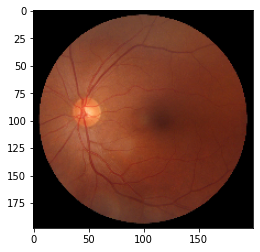

In [29]:
#before CLAHE processing
source = '/tmp/ODIR-5K/Training Images/112_left.jpg'
test = crop_image(source)
test = np.array(test)
img = tf.keras.preprocessing.image.array_to_img(test)
plt.imshow(img)
test = np.expand_dims(test, axis=0)
test.shape

(1, 200, 200, 3)

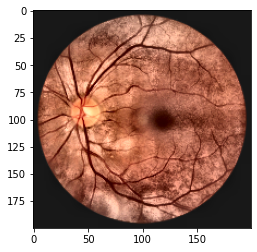

In [30]:
#showing CLAHE image Preprocessing
source = '/tmp/ODIR-5K/Training Images/112_left.jpg'
test = CLAHE(source, (200,200), 20, (10,10))
test = np.array(test)
img = tf.keras.preprocessing.image.array_to_img(test)
plt.imshow(img)
test = test.reshape(1, 200, 200, 3)
test.shape

In [31]:
#set target size image

target_size = (230, 230)
# color_mode = 'grayscale'
color_mode = 'rgb'
if color_mode == 'grayscale':
  shapeadd = (1,)
if color_mode == 'rgb':
  shapeadd = (3,)

## synthetizing the label for single image

In [32]:
#function for generate label to single image

#return index in key of all diagnosis list
def getIndexLabel(key, mKeyAll):
  # print(key)
  for ilist in mKeyAll:
    if key in ilist:
      # print(mKeyAll.index(ilist))
      return mKeyAll.index(ilist)

#return multilabel by index
def getMultiLabelFromKeys(indexLabel):
  temp_label = []
  for i in range(8):
    if i in indexLabel:
      temp_label.append(1)
    else :
      temp_label.append(0)
  return temp_label
  # print(right_label)

In [33]:
syntetic_labels = []
syntetic_features = []
image_array = []
processed_image_array = []
clahe_image = []
list_clahe = []
path = '/tmp/ODIR-5K/Training Images/'
for i in range(len(df)):
  oneHotIndexLeft = []
  oneHotIndexRight = []
  for left_key in leftEyeKeywords[i]:
    oneHotIndexLeft.append(getIndexLabel(left_key, keyAll))
  for right_key in rightEyeKeywords[i]:
    oneHotIndexRight.append(getIndexLabel(right_key, keyAll))
  oneHotIndexLeft = list(set(oneHotIndexLeft))
  oneHotIndexRight = list(set(oneHotIndexRight))
  syntetic_labels.append(getMultiLabelFromKeys(oneHotIndexLeft))
  syntetic_labels.append(getMultiLabelFromKeys(oneHotIndexRight))
  syntetic_features.append(df['Left-Fundus'][i])
  syntetic_features.append(df['Right-Fundus'][i])
  clahe_image.append(CLAHE(path+df['Left-Fundus'][i], target_size, 20, (10,10)))
  clahe_image.append(CLAHE(path+df['Right-Fundus'][i], target_size, 20, (10,10)))

## split feature, label, and file name for training, validation and test

In [34]:
import numpy as np
from sklearn.model_selection import train_test_split

clahe_image = np.stack(clahe_image, axis=0)
syntetic_labels = np.asarray(syntetic_labels)

training_features, temp_validation_features, training_labels, temp_validation_labels, training_filenames, temp_validation_filenames = train_test_split(clahe_image, syntetic_labels, syntetic_features, test_size=0.102, random_state=1)

validation_features, validation_test_features, validation_labels, validation_test_labels, validation_filenames, validation_test_filenames = train_test_split(temp_validation_features, temp_validation_labels, temp_validation_filenames, test_size=0.02, random_state=1)

print("n training :", len(training_filenames))
print("n validation :", len(validation_filenames))
print("n validation test :", len(validation_test_filenames))

#delete temporary list file for minimalizing memory usage
del clahe_image
del syntetic_labels
del temp_validation_features
del temp_validation_labels
del temp_validation_filenames

n training : 6286
n validation : 699
n validation test : 15


## show some image for training

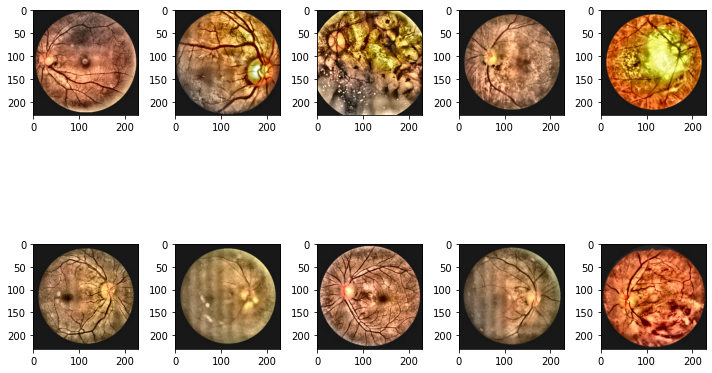

In [35]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        if color_mode == 'rgb':
          ax[i,j].imshow(training_features[k].reshape(target_size[0], target_size[1], 3) , cmap = "hsv")
        else :
          ax[i,j].imshow(training_features[k].reshape(target_size[0], target_size[1]) , cmap = "gray")
        k += 1
    plt.tight_layout()  

## show some image for validation

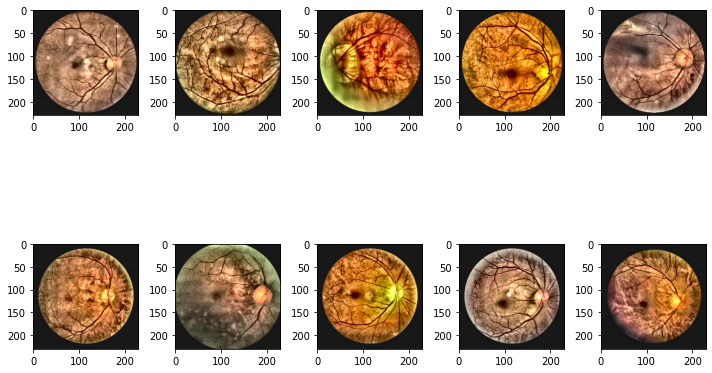

In [36]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(validation_features[k].reshape(target_size[0], target_size[1], 3) , cmap = "hsv")
        k += 1
    plt.tight_layout()  

## set image data generator for training

In [37]:
train_datagen = ImageDataGenerator(
                                  rescale = 1./255,
                                  rotation_range=30,
                                  horizontal_flip=True,
                                  # shear_range=0.2,
                                  # zoom_range=0.2,
                                  # fill_mode='nearest',
                                  # vertical_flip=False
                                  # featurewise_center=True,  # set input mean to 0 over the dataset
                                  # featurewise_std_normalization=True,  # divide inputs by std of the dataset
                                  # samplewise_std_normalization=True,  # divide each input by its std
                                  # samplewise_center=True,  # set each sample mean to 0
                                  # zca_whitening=False,  # apply ZCA whitening
                                  # validation_split=0.1,
                                  )

# train_datagen.fit(feature_images)

train_generator = train_datagen.flow(
                                    training_features, 
                                    y=training_labels, 
                                    batch_size=32,
                                    # subset='training'
                                    )

validation_datagen = ImageDataGenerator(
                                        rescale = 1./255,
                                        )

validation_generator = validation_datagen.flow(
                                          validation_features, 
                                          y=validation_labels, 
                                          batch_size=32,
                                          # subset='validation'
                                          )

# train_datagen_noaugment = ImageDataGenerator(
#                                     rescale = 1./255,
#                                     )

# train_generator_noaugment = train_datagen_noaugment.flow(
#                                     training_features, 
#                                     y=training_labels, 
#                                     batch_size=32,
#                                     # subset='training'
#                                     )

# Train

## set callback method

In [38]:
checkpoint_path = "/content/gdrive/My Drive/Trained_Models/ODIR5K/ODIR5K.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                #  save_weights_only=True,
                                                 verbose=1)

stopAccuracy = 0.950
stopValAccuracy = 0.8970
stopValAUC = 0.8200
stopValF1 = 0.5110

# Define a Callback class that stops training once accuracy reaches the certain accuracy
class callbackStop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy_multilabel') > stopAccuracy or logs.get('val_accuracy_multilabel') > stopValAccuracy or logs.get('val_auc_value') > stopValAUC or logs.get('val_f1_at_k') > stopValF1):
      print("\nReached stoping value so cancelling training!")
      self.model.stop_training = True

callbackstop = callbackStop()

## set metric for training

In [39]:
AUC_value = tf.keras.metrics.AUC(
                                  name='auc_value',
                                  # num_thresholds=200, 
                                  curve='ROC', 
                                  summation_method='interpolation',
                                  # thresholds=0.5, 
                                  multi_label=True,
                                  )

kappa_score = tfa.metrics.CohenKappa(
                                      num_classes=8,
                                      name='kappa score',
                                      # sparse_labels=False,
                                      # regression=False,
                                      # weightage='quadratic',
                                      # dtype=np.int32,
                                    )

F1_score = tfa.metrics.F1Score(
                                num_classes=8,
                                name='F-1 score',
                                average='macro',
                                threshold=0.5,
                              )

In [40]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

@tf.function
def accuracy_multilabel(y, y_hat):
  correct_prediction = tf.equal(tf.round(y_hat), y)
  # correct_prediction = tf.equal(tf.round(tf.nn.sigmoid(y_hat)), tf.round(y))
  ##mean
  correct_prediction = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  ##all
  # all_labels_true = tf.reduce_min(tf.cast(correct_prediction, tf.float32), 1)
  # correct_prediction = tf.reduce_mean(all_labels_true)
  return correct_prediction

@tf.function
def accuracy_multilabel2(y, y_hat):
  correct_prediction = tf.equal(tf.round(y_hat), tf.round(y))
  # correct_prediction = tf.equal(tf.round(tf.nn.sigmoid(y_hat)), tf.round(y))
  ##mean
  # correct_prediction = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  ##all
  correct_prediction = tf.reduce_min(tf.cast(correct_prediction, tf.float32), 1)
  correct_prediction = tf.reduce_mean(correct_prediction)
  return correct_prediction

@tf.function
def exact_match_fn(y_true, y_logits):
    threshold=0.5
    #pred = tf.equal(tf.round(y_logits), tf.round(y_true))
    predictions = tf.cast(tf.greater_equal(y_logits, threshold), dtype=tf.float32)
    pred_match = tf.equal(predictions, tf.round(y_true))
    exact_match = tf.reduce_min(tf.cast(pred_match, dtype=tf.float32), axis=1)
    return exact_match

@tf.function
def exact_match_prop_fn(*args):
    return tf.reduce_mean(exact_match_fn(*args))

K = tf.keras.backend

class MetricsAtTopK:
    def __init__(self, k):
        self.k = k

    def _get_prediction_tensor(self, y_pred):
        """Takes y_pred and creates a tensor of same shape with 1 in indices where, the values are in top_k
        """
        topk_values, topk_indices = tf.nn.top_k(y_pred, k=self.k, sorted=False, name="topk")
        # the topk_indices are along last axis (1). Add indices for axis=0
        ii, _ = tf.meshgrid(tf.range(tf.shape(y_pred)[0]), tf.range(self.k), indexing='ij')
        index_tensor = tf.reshape(tf.stack([ii, topk_indices], axis=-1), shape=(-1, 2))
        prediction_tensor = y_pred
        # prediction_tensor =  tf.sparse.to_dense(sparse_indices=index_tensor,
        #                                        output_shape=tf.shape(y_pred),
        #                                        default_value=0,
        #                                        sparse_values=1.0,
        #                                        validate_indices=False
        #                                        )
        prediction_tensor = tf.cast(prediction_tensor, K.floatx())
        return prediction_tensor

    def true_positives_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        return true_positive

    def false_positives_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        c2 = K.sum(prediction_tensor)  # TP + FP
        false_positive = c2 - true_positive
        return false_positive

    def false_negatives_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        c3 = K.sum(y_true)  # TP + FN
        false_negative = c3 - true_positive
        return false_negative

    def precision_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        c2 = K.sum(prediction_tensor)  # TP + FP
        return true_positive/(c2+K.epsilon())

    def recall_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        c3 = K.sum(y_true)  # TP + FN
        return true_positive/(c3+K.epsilon())

    def f1_at_k(self, y_true, y_pred):
        precision = self.precision_at_k(y_true=y_true, y_pred=y_pred)
        recall = self.recall_at_k(y_true=y_true, y_pred=y_pred)
        f1 = (2*precision*recall)/(precision+recall+K.epsilon())
        return f1

metricsAtTopK = MetricsAtTopK(k=5)

@tf.function
def hamming_loss(y_true, y_pred, mode='multiclass'):
    if mode not in ['multiclass', 'multilabel']:
        raise TypeError('mode must be: [multiclass, multilabel])')

    if mode == 'multiclass':
        nonzero = tf.cast(tf.math.count_nonzero(y_true * y_pred, axis=-1), tf.float32)
        print(nonzero)
        return 1.0 - nonzero

    else:
        nonzero = tf.cast(tf.math.count_nonzero(y_true - y_pred, axis=-1), 
            tf.float32)
        return nonzero / y_true.get_shape()[-1]


class HammingLoss(tf.python.keras.metrics.MeanMetricWrapper):
    def __init__(self, name='hamming_loss', dtype=None, mode='multiclass'):
        super(HammingLoss, self).__init__(
                hamming_loss, name, dtype=dtype, mode=mode)

hlmetric = HammingLoss()

## set loss function for training

In [41]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

@tf.function
def multilabel_cross_entropy(y, y_hat):
  # cross_entropy = -tf.reduce_sum( (  (y*tf.math.log(y_hat + 1e-9)) + ((1-y) * tf.math.log(1 - y_hat + 1e-9)) )  , name='xentropy' )
  # cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_hat, name="sigmoid_cross_entropy_with_logits")
  cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=y_hat, labels=tf.cast(y,tf.float32))
  loss = tf.reduce_mean(tf.reduce_sum(cross_entropy, axis=1))
  return loss

@tf.function
def npairs_multilabel_loss(y_true, y_pred):
  y_pred = tf.matmul(y_true, y_pred, transpose_a=False, transpose_b=True)
  loss = tfa.losses.npairs_multilabel_loss(y, y_pred)
  return loss

@tf.function
def hamming_loss_func(y_true, y_pred):
  diff = tf.cast(y_true - y_pred, dtype=tf.float32)
  
  #Counting non-zeros in a differentiable way
  epsilon = K.epsilon()
  nonzero = tf.reduce_sum( tf.math.abs( diff / (tf.math.abs(diff) + epsilon) ))

  return tf.reduce_mean(nonzero / K.int_shape(y_pred)[-1])


##Define Model

In [42]:
# use_model = "use transfer learning using vgg19"
# use_model = "use transfer learning using mobilenetv2"
use_model = "using custom"

In [43]:
if ("use transfer learning" in use_model):

  if("using vgg19" in use_model):
    base_model= tf.keras.applications.VGG19(include_top=False, weights="imagenet", input_shape=target_size+shapeadd,)
    model_path = '/content/gdrive/My Drive/Trained_Models/ODIR-5K-VGG19-Multi-Label/'

  if("using mobilenetv2" in use_model):
    base_model= tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=target_size+shapeadd,)
    model_path = '/content/gdrive/My Drive/Trained_Models/ODIR-5K-MobileNetV2-Multi-Label/'

  for layer in base_model.layers:
    layer.trainable = False

  base_model.summary()
  # last_layer = base_model.get_layer('block4_pool')
  # conn = last_layer.output

  conn = base_model.output

  conn = tf.keras.layers.Flatten()(conn)
  conn = tf.keras.layers.Dense(256, activation='relu', 
                              kernel_regularizer=tf.keras.regularizers.l2(0.001),
                              )(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)
  # conn = tf.keras.layers.Dropout(0.2)(conn)
  conn = tf.keras.layers.Dense(128, activation='relu', 
                               kernel_regularizer=tf.keras.regularizers.l2(0.001),
                              )(conn)
  # # conn = tf.keras.layers.BatchNormalization()(conn)
  # conn = tf.keras.layers.Dropout(0.4)(conn)
  # conn = tf.keras.layers.Dense(96, activation='relu', 
  #                              kernel_regularizer=tf.keras.regularizers.l2(0.001),
  #                              )(conn)
  # conn = tf.keras.layers.BatchNormalization()(conn)
  conn = tf.keras.layers.Dropout(0.2)(conn)
  # conn = tf.keras.layers.Dense(64, activation='relu', 
  #                             kernel_regularizer=tf.keras.regularizers.l2(0.001),
  #                             )(conn)
  # # conn = tf.keras.layers.BatchNormalization()(conn)
  # conn = tf.keras.layers.Dropout(0.4)(conn)
  conn = tf.keras.layers.Dense(8, activation='sigmoid')(conn)
if (use_model == "using custom"):
  model_path = '/content/gdrive/My Drive/Trained_Models/ODIR-5K-VGG16_like-Multi-Label/'

  inputs = tf.keras.Input(shape=target_size+shapeadd)
  # The first convolution
  conn = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
  conn = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.MaxPooling2D(2, 2)(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)
  # conn = tf.keras.layers.Dropout(0.4)(conn)

  # The second convolution
  conn = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.MaxPooling2D(2,2)(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)
  # conn = tf.keras.layers.Dropout(0.4)(conn)

  # The third convolution
  conn = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.MaxPooling2D(2,2)(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)
  # conn = tf.keras.layers.Dropout(0.4)(conn)

  # The fourth convolution
  conn = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.MaxPooling2D(2,2)(conn)
  # conn = tf.keras.layers.Dropout(0.4)(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)

  conn = tf.keras.layers.Flatten()(conn)
  conn = tf.keras.layers.Dense(256, activation='relu', 
                        kernel_regularizer=tf.keras.regularizers.l2(0.001),
                        )(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)
  # conn = tf.keras.layers.Dropout(0.4)(conn)
  conn = tf.keras.layers.Dense(128, activation='relu', 
                        kernel_regularizer=tf.keras.regularizers.l2(0.001),
                        )(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)
  # conn = tf.keras.layers.Dropout(0.4)(conn)
  # conn = tf.keras.layers.Dense(96, activation='relu', 
  #                       kernel_regularizer=tf.keras.regularizers.l2(0.001),
  #                       )(conn)
  # conn = tf.keras.layers.BatchNormalization()(conn)
  # conn = tf.keras.layers.Dropout(0.2)(conn)
  conn = tf.keras.layers.Dense(64, activation='relu', 
                        # kernel_regularizer=tf.keras.regularizers.l2(0.001),
                        )(conn)
  # conn = tf.keras.layers.Dropout(0.4)(conn)
  conn = tf.keras.layers.Dense(8, activation='sigmoid')(conn)

training dataset

In [44]:
use_training_model = False

checkpoint_path = model_path+'ODIR5K.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
model_save_weights = 'weight'
model_save_name_h5 = 'ODIR5K.h5'
model_save_name_tf = 'ODIR5K_TF'
model_save_name_js = 'ODIR5K_TFJS'

nEpoch = 25
# target_size = (200,200)
# shapeadd = (3,)
input_shape = target_size + shapeadd
learning_rate = 1e-4
# loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
loss = "binary_crossentropy"
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# tf.keras.optimizers.SGD(learning_rate=learning_rate)


if (os.path.isfile(model_path+model_save_name_h5) or os.path.exists(model_path+model_save_name_tf)) and use_training_model:
  # if os.path.exists(model_path+model_save_name_tf):
  #   print("using tf")
  #   model = tf.keras.models.load_model(model_path+model_save_name_tf)
  if os.path.isfile(model_path+model_save_name_h5):
    print("using h5")
    model = tf.keras.models.load_model(model_path+model_save_name_h5)
  output = model.output
else:
  print("no using saved model")
  if (use_model == "using custom"):
    model = tf.keras.Model(inputs=inputs, outputs=conn)
  else:
    model = tf.keras.Model(base_model.input, conn)
  # model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()
model.compile(loss=
                    'binary_crossentropy',
                    # macro_soft_f1, # not suitable loss for multilabel
                    # npairs_multilabel_loss, #cannot use in this model
                    # hamming_loss_func
                    
              optimizer=optimizer, 
              metrics=[
                       accuracy_multilabel,
                      #  'accuracy', # not suitable metric for multilabel
                      #  macro_f1, # not suitable metric for multilabel
                       metricsAtTopK.f1_at_k,
                      #  F1_score, # not suitable metric for multilabel
                      #  kappa_score, #cannot in multilabel
                       AUC_value,
                       # hamming_loss, #cannot apply
                       ]
              )

no using saved model
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 230, 230, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 228, 228, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 226, 226, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 113, 113, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 113, 113, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109,

In [45]:
history = model.fit(
                    train_generator,
                    # train_generator_noaugment, 
                    validation_data=validation_generator, 
                    epochs=50,
                    # steps_per_epoch=100,
                    # batch_size=train_generator.batch_size,
                    # steps_per_epoch = train_generator.samples // train_generator.batch_size,
                    # validation_steps = validation_generator.samples // validaition_generator.batch_size,
                    verbose=1,
                    callbacks=[
                               callbackstop, 
                              #  cp_callback
                               ],
                    )

Epoch 1/50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
197/197 [==============================] - 67s 340ms/step - loss: 1.0532 - accuracy_multilabel: 0.8337 - f1_at_k: 0.2860 - auc_value: 0.6178 - val_loss: 1.0434 - val_accuracy_multilabel: 0.7550 - val_f1_at_k: 0.1810 - val_auc_value: 0.5533
Epoch 2/50
197/197 [==============================] - 67s 341ms/step - loss: 0.9041 - accuracy_multilabel: 0.8723 - f1_at_k: 0.3286 - auc_value: 0.6995 - val_loss: 1.1113 - val_accuracy_multilabel: 0.7571 - val_f1_at_k: 0.1166 - val_auc_value: 0.5358
Epoch 3/50
197/197 [==============================] - 67s 340ms/step - loss: 0.8166 - accuracy_multilabel: 0.8750 - f1_at_k: 0.3503 - auc_value: 0.7301 - val_loss: 0.8312 - val_accuracy_multilabel: 0.8549 - val_f1_at_k: 0.2987 - val_auc_value: 0.6473
Epoch 4/50
197/197 [==============================] - 66s 336ms/step - loss: 0.7365 - accuracy_multilabel: 0.8760 - f1_at_k: 0.3642 - auc_value: 0.7510 - val_loss: 0.

# Evaluate

## Validation test trained model

In [46]:
training_path = '/tmp/ODIR-5K/Training Images/'
traininglist = os.listdir('/tmp/ODIR-5K/Training Images/')
output = tfa.metrics.MultiLabelConfusionMatrix(num_classes=8)
print("file name", "\t\t\t\t\t", "true label", "\t\t", "prediction label","\t", "accuracy score")
count_true = 0
count_half = 0
count_zero = 0
for i in range(0, len(validation_test_filenames)):
  source = training_path+validation_test_filenames[i]
  # img = tf.keras.preprocessing.image.load_img(source, target_size=target_size,)
  img = CLAHE(source, target_size, 20, (10,10))
  # cv_imshow(img)
  imgarray = tf.keras.preprocessing.image.img_to_array(img)
  imgarray = np.expand_dims(imgarray, axis=0)
  imgarray = imgarray/255.0
  images = np.vstack([imgarray])
  predict = model.predict(images)
  # print(predict.shape)
  predict = predict.reshape(8)
  # y_true = validation_test_labels[i].reshape(1,8)
  predict = tf.cast(predict >= 0.5, np.int32)
  y_true = tf.constant(validation_test_labels[i], dtype=tf.int32)
  y_pred = tf.constant(predict.numpy(), dtype=tf.int32)
  accml = accuracy_multilabel(y_true, y_pred).numpy()
  count_true = count_true + 1 if accml == 1.0 else count_true
  count_half = count_half + 1 if 0.75 <= accml < 1 and 1 in predict.numpy().tolist() else count_half
  count_zero = count_zero + 1 if 1 not in predict.numpy().tolist() else count_zero
  # output.update_state(y_true, y_pred)
  print("---------------------------------------------------------------------------------------------------")
  print(source, "\t", validation_test_labels[i], "\t", predict.numpy(), "\t", accml)
  # print(output.result().numpy())

print('\n',"true :", count_true, "| half true :", count_half, "| zero :", count_zero)

file name 					 true label 		 prediction label 	 accuracy score
---------------------------------------------------------------------------------------------------
/tmp/ODIR-5K/Training Images/1492_right.jpg 	 [0 0 1 0 0 0 0 0] 	 [1 0 0 0 0 0 0 0] 	 0.75
---------------------------------------------------------------------------------------------------
/tmp/ODIR-5K/Training Images/2926_right.jpg 	 [1 0 0 0 0 0 0 0] 	 [1 0 0 0 0 0 0 0] 	 1.0
---------------------------------------------------------------------------------------------------
/tmp/ODIR-5K/Training Images/1594_right.jpg 	 [0 0 0 0 0 0 1 0] 	 [0 0 0 0 0 0 1 0] 	 1.0
---------------------------------------------------------------------------------------------------
/tmp/ODIR-5K/Training Images/4235_right.jpg 	 [0 1 0 0 0 0 0 0] 	 [1 0 0 0 0 0 0 0] 	 0.75
---------------------------------------------------------------------------------------------------
/tmp/ODIR-5K/Training Images/4293_right.jpg 	 [0 1 0 0 0 0 0 0] 	 [1 0 0 0

## save the trained model

In [48]:
model.save_weights(model_path)
model.save_weights(model_path+model_save_weights)
model.save(model_path)
model.save(model_path+model_save_name_h5)
model.save(model_path+model_save_name_tf,save_format='tf')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Trained_Models/ODIR-5K-VGG16_like-Multi-Label/assets
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Trained_Models/ODIR-5K-VGG16_like-Multi-Label/ODIR5K_TF/assets


In [51]:
!pip install tensorflowjs
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, model_path+model_save_name_js)

/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:122: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [52]:
converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
tflite_model = converter.convert()
open(model_path+"ODIR5K.tflite", "wb").write(tflite_model)

31091756

##plot the training and validation step

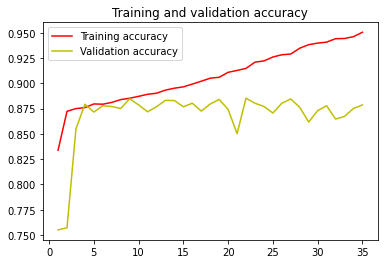

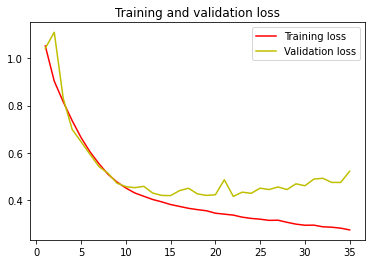

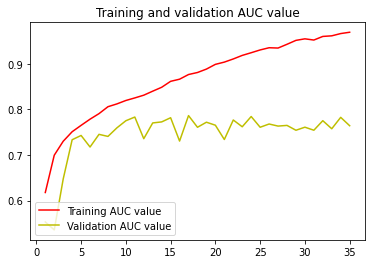

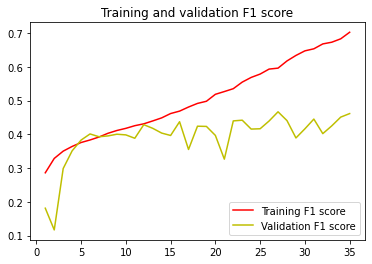

<Figure size 432x288 with 0 Axes>

In [53]:
f1_str = 'f1_at_k'
val_f1_str = 'val_'+f1_str

acc = history.history['accuracy_multilabel']
val_acc = history.history['val_accuracy_multilabel']

loss = history.history['loss']
val_loss = history.history['val_loss']

# kappa = history.history['kappa score']
# val_kappa = history.history['val_kappa score']

f1 = history.history[f1_str]
val_f1 = history.history[val_f1_str]

auc = history.history['auc_value']
val_auc = history.history['val_auc_value']

epochs_training = range(1, len(acc)+1)

plt.plot(epochs_training, acc, 'r', label='Training accuracy')
plt.plot(epochs_training, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.savefig(model_path+'accuracy.png')

plt.plot(epochs_training, loss, 'r', label='Training loss')
plt.plot(epochs_training, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=1)
plt.figure()
plt.savefig(model_path+'loss.png')

# plt.plot(epochs_training, kappa, 'r', label='Training kappa score')
# plt.plot(epochs_training, val_kappa, 'y', label='Validation kappa score')
# plt.title('Training and validation kappa score')
# plt.legend(loc=2)
# plt.figure()

plt.plot(epochs_training, auc, 'r', label='Training AUC value')
plt.plot(epochs_training, val_auc, 'y', label='Validation AUC value')
plt.title('Training and validation AUC value')
plt.legend(loc=3)
plt.figure()
plt.savefig(model_path+'AUC.png')

plt.plot(epochs_training, f1, 'r', label='Training F1 score')
plt.plot(epochs_training, val_f1, 'y', label='Validation F1 score')
plt.title('Training and validation F1 score')
plt.legend(loc=4)
plt.figure()
plt.savefig(model_path+'f1 top 5.png')


plt.show()

## testing model

In [54]:
# for ifile in testlist:
test_path = '/tmp/ODIR-5K/Testing Images/'
testlist = os.listdir('/tmp/ODIR-5K/Testing Images/')
testlist.sort()
# source = '/tmp/ODIR-5K/Training Images/12_left.jpg'
for i in range(0, len(testlist), 5):
  source = test_path+testlist[i]
  # img = tf.keras.preprocessing.image.load_img(source, target_size=target_size,)
  img = CLAHE(source, target_size, 20, (10,10))
  # cv_imshow(img)
  imgarray = tf.keras.preprocessing.image.img_to_array(img)
  imgarray = np.expand_dims(imgarray, axis=0)
  images = np.vstack([imgarray])/255
  classes = model.predict(images)
  # print(classes, '\n')
  classes = tf.cast(classes > 0.5, float)
  print(source, classes)

/tmp/ODIR-5K/Testing Images/1000_left.jpg tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 8), dtype=float32)
/tmp/ODIR-5K/Testing Images/1002_right.jpg tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 8), dtype=float32)
/tmp/ODIR-5K/Testing Images/1007_left.jpg tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 8), dtype=float32)
/tmp/ODIR-5K/Testing Images/1026_right.jpg tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 8), dtype=float32)
/tmp/ODIR-5K/Testing Images/1030_left.jpg tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 8), dtype=float32)
/tmp/ODIR-5K/Testing Images/1042_right.jpg tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 8), dtype=float32)
/tmp/ODIR-5K/Testing Images/1049_left.jpg tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 8), dtype=float32)
/tmp/ODIR-5K/Testing Images/1055_right.jpg tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 8), dtype=float32)
/tmp/ODIR-5K/Testing Images/1067_left.jpg tf.Tensor([[0. 1. 0. 0. 0. 0. 0. 0.]], shape=(1, 8), dtype=float32)
/tmp/O

# Commit trained model to repository

In [ ]:
os.chdir('/tmp/github')

In [ ]:
!git config --global credential.helper store

In [ ]:
!sudo apt-get install git-lfs

In [ ]:
!git lfs install

In [ ]:
!git lfs track "*.psd"

In [ ]:
!git add .gitattributes

In [ ]:
!git lfs track "*.h5" "*.pb" "*.tflite" "*.data-00000-of-00002" "*.data-00001-of-00002" "*.data-00001-of-00002" "models/ODIR5K-bottleneck/ODIR5K.h5" "models/ODIR5K-bottleneck/ODIR5K_TF/variables/variables.data-00001-of-00002" "models/ODIR5K-bottleneck/.data-00001-of-00002"

In [ ]:
!ls models/ODIR5K-bottleneck/assets

In [ ]:
!rm -rf /tmp/github/ocular-disease-recognition-5k/models/ODIR5K-bottleneck

In [ ]:
!git lsf add .

In [ ]:
!git push origin master

In [ ]:
!git push

In [ ]:
!rm -rf /tmp/github/ocular-disease-recognition-5k/.lfsconfig